# **Image Captioning**

The process of generating descriptions of the image using pretrained models.

We have opted to use the Encoder - Decoder architecture using CNN and RNN respectively.

Steps include:


*   Data Setup
*   Preprocessing - Tokenization
*   Image feature extraction - Converts images into feature vectors
*   Data Generator - Converts data into smaller batches for efficient processing
*   Build Model with CNN to process feature vector and LSTM to process captions
*   Training
*   **Testing**







## Setup

**Import Data from Kaggle**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

/Users/nandalavamshi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/nandalavamshi/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/nandalavamshi/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


**Import initial libraries**

In [2]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

**Display captions**

In [3]:
data = pd.read_csv(path + "/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


**Display Images**

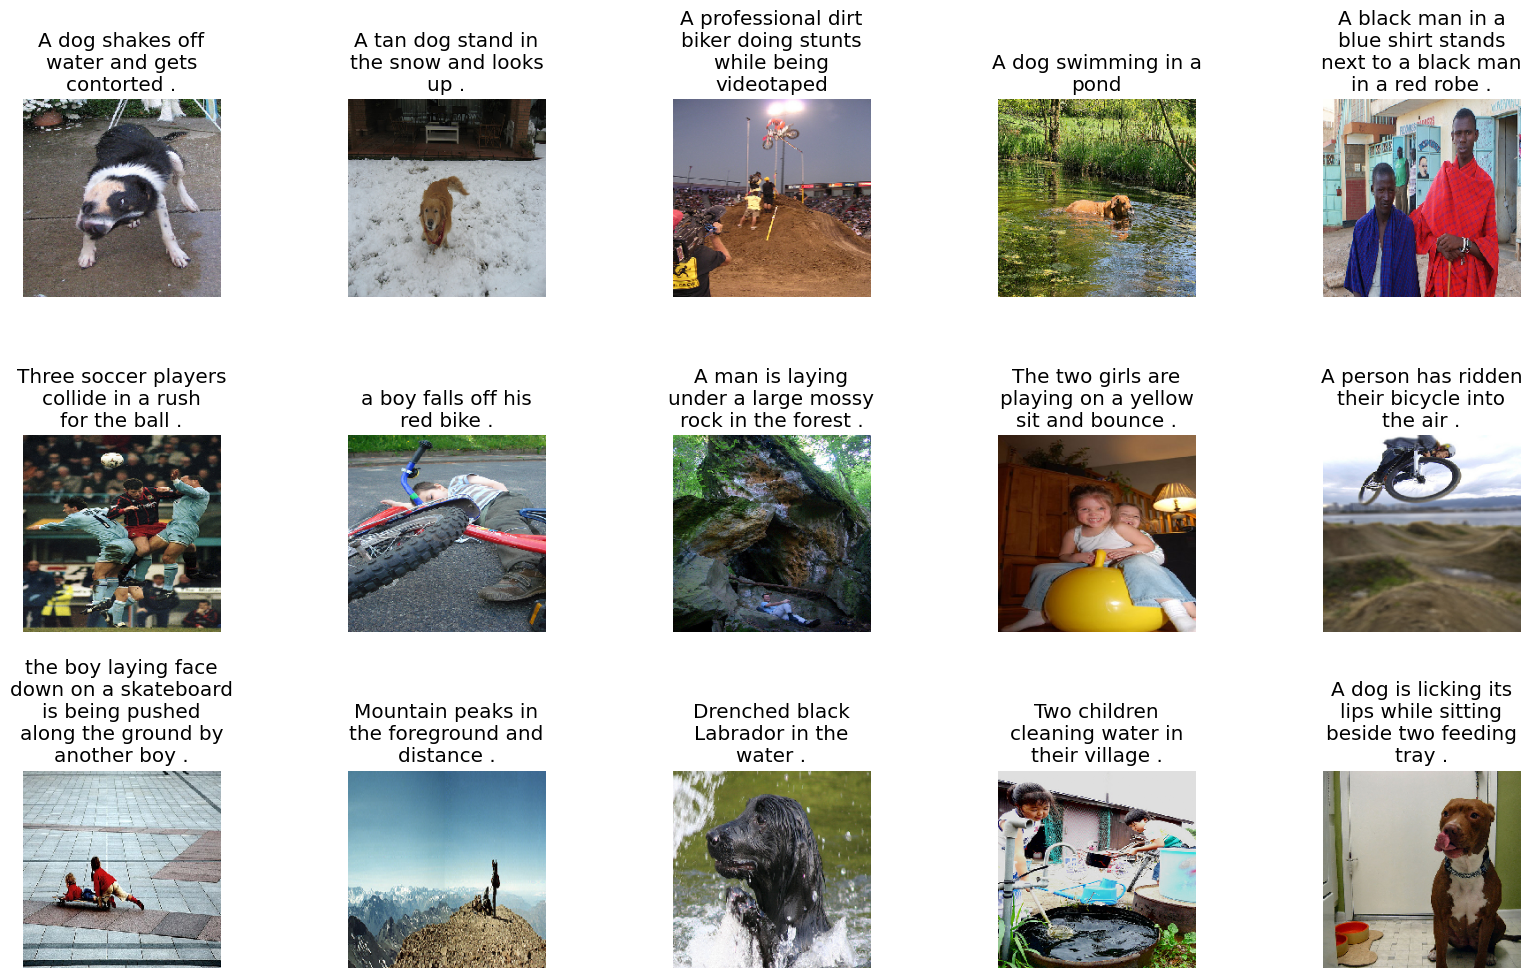

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from textwrap import wrap

image_path = path + "/Images"

def visualizeImages(data):
    data = data.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = load_img(image_path+ f"/{data.image[i]}",color_mode='rgb',target_size=(224, 224))
        image = img_to_array(image)
        image = image/255.
        plt.imshow(image)
        plt.title("\n".join(wrap(data.caption[i], 20)))
        plt.axis("off")

visualizeImages(data.sample(15))

## Data Preprocessing
**Caption Preprocessing**



In [5]:
data['caption'] = data['caption'].apply(lambda x: x.lower())
data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
data['caption'] = "startseq "+data['caption']+" endseq"
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

**Tokenization**

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

## Image Feature Extraction


In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tqdm import tqdm
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

 56%|█████▌    | 4548/8091 [08:37<06:56,  8.51it/s]

## Data Generation


In [ ]:
from tensorflow.keras.utils import Sequence
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [ ]:
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.layers import Embedding, LSTM, add, Reshape, concatenate
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

NameError: name 'max_length' is not defined

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

/Users/nandalavamshi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


NameError: name 'caption_model' is not defined

In [ ]:
import sys
print(sys.executable)


/Applications/Xcode.app/Contents/Developer/usr/bin/python3


In [ ]:
import os
print(os.getcwd())



/Users/nandalavamshi/Desktop/DEEP-LEARNING/Project/Deeplearning-imagecaptioning


import sys
print(sys.executable)
